<a href="https://colab.research.google.com/github/carloshernangarrido/vibration-control/blob/master/2dof_str_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [212]:
%reset -f

from typing import List, Union
import sympy as sm

# For simulation
import numpy as np # provides basic array types and some linear algebra
import matplotlib.pyplot as plt # used for plots

# For transfer function and state space representations
import scipy as sp
eps = 1e-6

# System definition

## Structural Equation Of Motion

In [213]:
# mass, stiffness and damping
m1, c1, k1, m2, c12, k12, t = sm.symbols('m1, c1, k1, m2, c12, k12, t')
# inertance
b1, b12 = sm.symbols('b1, b12')

# mass, stiffness and damping matrices
M_s = sm.Matrix([[m1 + b1 + b12, -b12],
                 [-b12,           m2 + b12]])

K_s = sm.Matrix([[k1 + k12, -k12],
                 [-k12,      k12]])

C_s = sm.Matrix([[c1 + c12, -c12],
                 [-c12,      c12]])

# Seismic excitation matrix
B_s = sm.Matrix([[m1],
                 [m2]])

## State space representation

In [214]:
# State space
# System matrix
A = sm.Matrix([[sm.zeros(2,2), sm.eye(2)], 
               [-M_s.inv()*K_s,    -M_s.inv()*C_s]])
# Seismic Input Matrix
B = sm.Matrix([[sm.zeros(2,1)],
               [-M_s.inv()*B_s]])
# Story drift Output Matrix
C = sm.Matrix([[1,  0, 0, 0],
               [-1, 1, 0, 0]])
# Direct Transfer Matrix
D = sm.Matrix([[0],
               [0]])

In [215]:
sm.simplify(A)

Matrix([
[                                                                           0,                                                         0,                                                                            1,                                                         0],
[                                                                           0,                                                         0,                                                                            0,                                                         1],
[(b12*k12 - (b12 + m2)*(k1 + k12))/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2),         k12*m2/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2), (b12*c12 - (b12 + m2)*(c1 + c12))/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2),         c12*m2/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2)],
[       (b1*k12 - b12*k1 + k12*m1)/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2), -k12*(b1 + m1)/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2),        (b1*c12 - b12*c1 +

In [216]:
sm.simplify(B)

Matrix([
[                                                                        0],
[                                                                        0],
[     -(b12*m2 + m1*(b12 + m2))/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2)],
[-(b12*m1 + m2*(b1 + b12 + m1))/(b1*b12 + b1*m2 + b12*m1 + b12*m2 + m1*m2)]])

In [217]:
sm.simplify(C)

Matrix([
[ 1, 0, 0, 0],
[-1, 1, 0, 0]])

In [218]:
sm.simplify(D)

Matrix([
[0],
[0]])

In [219]:
D.shape

(2, 1)

## Frequency domain

### Classes

In [230]:
class TF:
  def __init__(self, A, B, C, D, i_output, parameters, 
               w = np.linspace(0, 10, 10000)):
    A_num = np.array(A.subs(parameters), dtype=float)
    B_num = np.array(B.subs(parameters), dtype=float)
    C_num = np.array(C.subs(parameters), dtype=float)
    D_num = np.array(D.subs(parameters), dtype=float)
    self.num, self.den = sp.signal.ss2tf(A_num, B_num, C_num[i_output], D_num[i_output])
    self.num = [coef if (abs(coef) > eps) else 0 
                for coef in self.num[0]]
    self._tf = sp.signal.lti(self.num, self.den)
    self._freqresp_w, self._freqresp_H = self._tf.freqresp(w=w)
    
  def H_inf(self):
    return np.linalg.norm(self._freqresp_H, ord=np.inf)

  def H_2(self):
    return np.linalg.norm(self._freqresp_H, ord=2)


# Base parameters

## Classes

In [236]:
class Parameters:
  def __init__(self, base_parameters):
    self.base_parameters = base_parameters
  
  def get_parameters(self, alpha, b12_add, c12_add):
    parameters = self.base_parameters.copy()
    parameters['c1'] = alpha*parameters['k1']
    parameters['c12'] = alpha*parameters['k12']
    parameters['b12'] += b12_add
    parameters['c12'] += c12_add
    return parameters

## Values

In [238]:
## constans
# stiffness-proportional damping coefficient
alpha = 0.1

k1_c = 1
c1_c = alpha*k1_c
m1_c = 1
k12_c = 1
c12_c = alpha*k12_c
m2_c = 1
b1_c = 0
b12_c = 0

base_parameters = {'k1':  k1_c,
                   'c1':  c1_c,
                   'm1':  m1_c,
                   'k12': k12_c,
                   'c12': c12_c,
                   'm2':  m2_c,
                   'b1':  b1_c,
                   'b12': b12_c}

par = Parameters(base_parameters)


i_output = 0
print(TF(A, B, C, D, i_output, par.get_parameters(alpha,0,0))._tf)

TransferFunctionContinuous(
array([-1. , -0.2, -2. ]),
array([1.  , 0.3 , 3.01, 0.2 , 1.  ]),
dt: None
)


/usr/local/lib/python3.7/dist-packages/scipy/signal/filter_design.py:1632: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


# Parametric analysis

/usr/local/lib/python3.7/dist-packages/scipy/signal/filter_design.py:1632: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
/usr/local/lib/python3.7/dist-packages/scipy/signal/filter_design.py:1632: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
/usr/local/lib/python3.7/dist-packages/scipy/signal/filter_design.py:1632: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
/usr/local/lib/python3.7/dist-packages/scipy/signal/filter_design.py:1632: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


Text(0.5, 0, '$b_{12add}$')

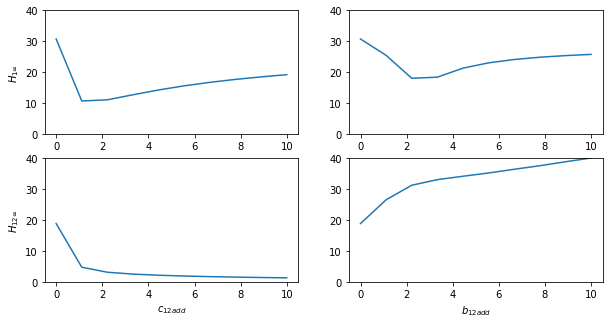

In [245]:
steps = 10
fig, ax = plt.subplots(2, 2, figsize=[10, 5])
c12_add = np.linspace(0, 100*c1_c, steps)
b12_add = np.linspace(0, 10, steps)

alpha = .1
H_1inf_b12_add = lambda x : TF(A, B, C, D, 0, 
                              par.get_parameters(alpha=alpha, b12_add=x, c12_add=0)).H_inf()
H_1inf_c12_add = lambda x : TF(A, B, C, D, 0, 
                              par.get_parameters(alpha=alpha, b12_add=0, c12_add=x)).H_inf()
H_12inf_b12_add = lambda x : TF(A, B, C, D, 1,
                                par.get_parameters(alpha=alpha, b12_add=x, c12_add=0)).H_inf()
H_12inf_c12_add = lambda x : TF(A, B, C, D, 1,
                                par.get_parameters(alpha=alpha, b12_add=0, c12_add=x)).H_inf()
ylim = (0,40)

ax[0,0].plot(c12_add, np.vectorize(H_1inf_c12_add)(c12_add))
ax[0,0].set_ylim(ylim)
ax[0,0].set_xlabel('$c_{12add}$')
ax[0,0].set_ylabel('$H_{1\infty}$')
ax[0,1].plot(b12_add, np.vectorize(H_1inf_b12_add)(b12_add))
ax[0,1].set_ylim(ylim)
ax[0,1].set_xlabel('$b_{12add}$')

ax[1,0].plot(c12_add, np.vectorize(H_12inf_c12_add)(c12_add))
ax[1,0].set_ylim(ylim)
ax[1,0].set_xlabel('$c_{12add}$')
ax[1,0].set_ylabel('$H_{12\infty}$')
ax[1,1].plot(b12_add, np.vectorize(H_12inf_b12_add)(b12_add))
ax[1,1].set_ylim(ylim)
ax[1,1].set_xlabel('$b_{12add}$')


# Optimization